Cleaning corrupted images...
Cleanup complete.
Found 3267 images belonging to 2 classes.
Found 816 images belonging to 2 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 373s 3s/step - accuracy: 0.8153 - loss: 0.4185 - val_accuracy: 0.6777 - val_loss: 0.6356
Epoch 2/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - accuracy: 0.8985 - loss: 0.2814 - val_accuracy: 0.6801 - val_loss: 0.7264
Epoch 3/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 338s 3s/step - accuracy: 0.9144 - loss: 0.2380 - val_accuracy: 0.6422 - val_loss: 0.9032
Epoch 4/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 347s 3s/step - accuracy: 0.9234 - loss: 0.2172 - val_accuracy: 0.6936 - val_loss: 0.7291
Epoch 5/5
103/103 ━━━━━━━━━━━━━━━━━━━━ 374s 3s/step - accuracy: 0.9259 - loss: 0.1947 - val_accuracy: 0.6642 - val_loss: 0.9500


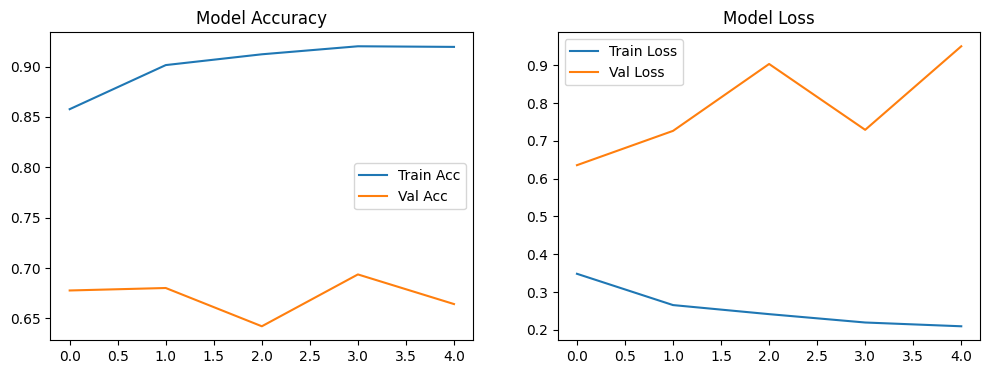

26/26 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step

Classification Report:

               precision    recall  f1-score   support

    Fractured       0.23      0.38      0.28       143
Non_fractured       0.85      0.73      0.78       673

     accuracy                           0.66       816
    macro avg       0.54      0.55      0.53       816
 weighted avg       0.74      0.66      0.69       816



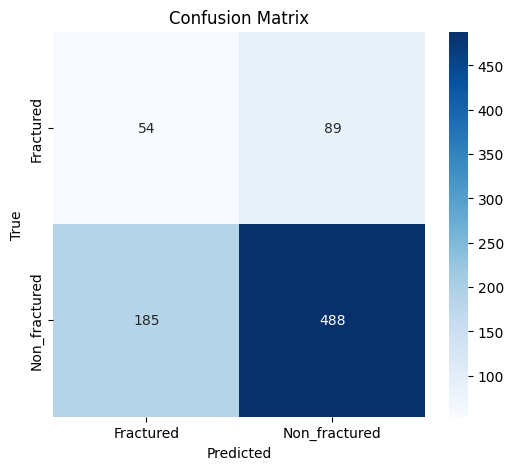

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


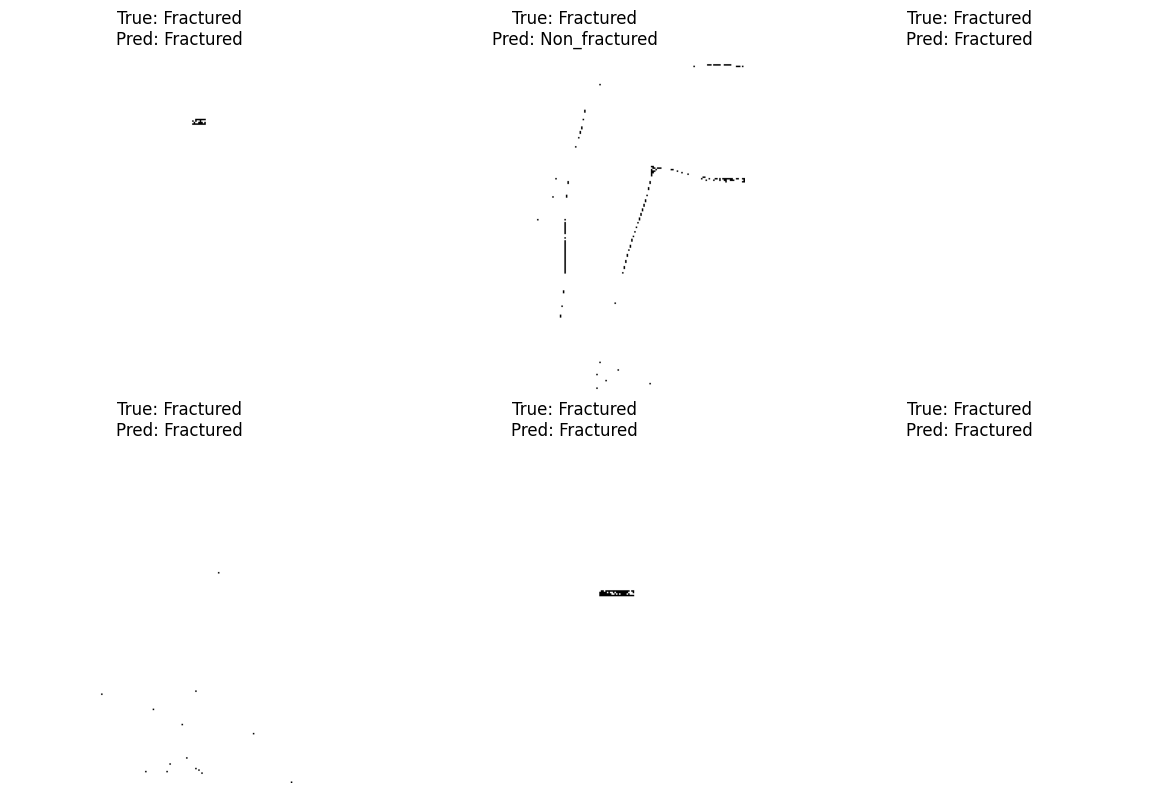

In [ ]:
# =============================
# Step 1: Imports and Cleanup
# =============================
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image, ImageFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import glob

# Allow loading of corrupted/truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# =============================
# Step 3: Define Paths
# =============================
fractured_path = '/content/drive/MyDrive/FracAtlas/images/Fractured'
non_fractured_path = '/content/drive/MyDrive/FracAtlas/images/Non_fractured'
root_path = '/content/drive/MyDrive/FracAtlas/images'

# =============================
# Step 4: Clean Corrupted Images
# =============================
print("Cleaning corrupted images...")
for folder in [fractured_path, non_fractured_path]:
    for img_path in glob.glob(folder + '/*'):
        try:
            img = Image.open(img_path)
            img.verify()
        except (IOError, SyntaxError) as e:
            print(f"Corrupted image removed: {img_path}")
            os.remove(img_path)
print("Cleanup complete.")

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# =============================
# Step 5: Image Data Generators (Updated for EfficientNet)
# =============================
datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input
)

train_generator = datagen.flow_from_directory(
    root_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    root_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

# =============================
# Step 6: EfficientNetB0 Model
# =============================
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# =============================
# Step 7: Train Model
# =============================
history = model.fit(train_generator, epochs=5, validation_data=val_generator)

# =============================
# Step 8: Accuracy/Loss Plots
# =============================
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# =============================
# Step 9: Confusion Matrix + Report
# =============================
val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.round(preds).astype(int).flatten()
y_true = val_generator.classes

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Fractured', 'Non_fractured']))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fractured', 'Non_fractured'],
            yticklabels=['Fractured', 'Non_fractured'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# =============================
# Step 10: Sample Predictions
# =============================
class_names = ['Fractured', 'Non_fractured']
val_generator.reset()
images, labels = next(val_generator)

plt.figure(figsize=(12, 8))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    plt.imshow(images[i])
    pred_label = model.predict(np.expand_dims(images[i], axis=0))[0][0]
    pred_class = class_names[int(round(pred_label))]
    true_class = class_names[int(labels[i])]
    plt.title(f"True: {true_class}\nPred: {pred_class}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input
)


In [ ]:
train_generator = datagen.flow_from_directory(
    root_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    root_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 3267 images belonging to 2 classes.
Found 816 images belonging to 2 classes.


In [ ]:
images, _ = next(val_generator)
print(images.min(), images.max())  # Should show something like: -1.0 to 1.0


0.0 255.0


In [ ]:
print("Preprocessed image range:", images[0].min(), images[0].max())


Preprocessed image range: 0.0 255.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_input  # This is critical
)


In [ ]:
train_generator = datagen.flow_from_directory(
    root_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    root_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 3267 images belonging to 2 classes.
Found 816 images belonging to 2 classes.


In [ ]:
images, _ = next(val_generator)
print(images.min(), images.max())
# Should now print values like: -1.0 1.0 or 0.0 1.0 (depending on the model)


0.0 250.0


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

def fixed_preprocess_input(image):
    image = tf.cast(image, tf.float32)
    return efficientnet_preprocess(image)


In [ ]:
datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=fixed_preprocess_input
)


In [ ]:
images, _ = next(val_generator)
print(images.min(), images.max())  # Should show something like: 0.0 1.0


0.0 243.0


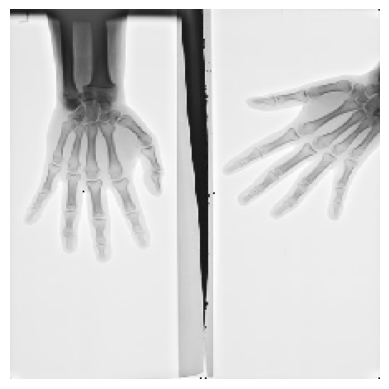

In [ ]:
import matplotlib.pyplot as plt
plt.imshow((images[0] * 255).astype("uint8"))
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step


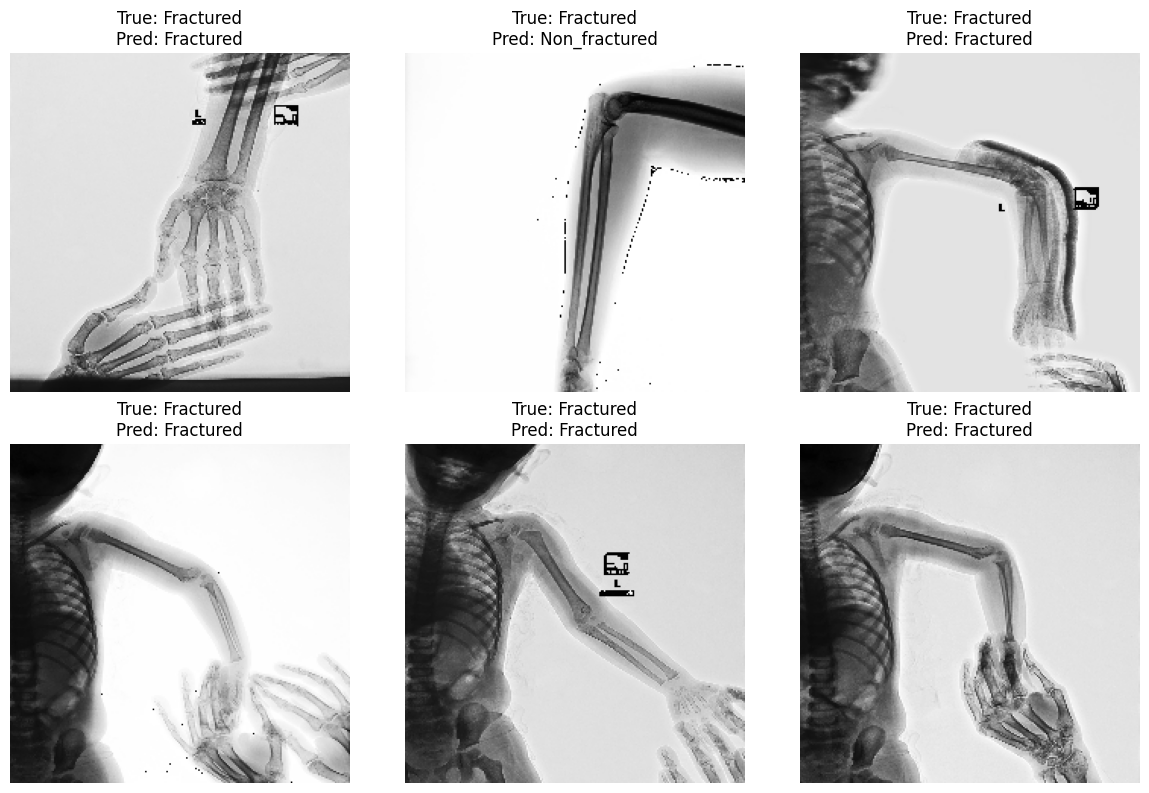

In [ ]:
plt.figure(figsize=(12, 8))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    display_img = (images[i] * 255).astype("uint8")  # restore to [0, 255]
    plt.imshow(display_img)

    pred_label = model.predict(np.expand_dims(images[i], axis=0))[0][0]
    pred_class = class_names[int(round(pred_label))]
    true_class = class_names[int(labels[i])]

    plt.title(f"True: {true_class}\nPred: {pred_class}")
    plt.axis("off")
plt.tight_layout()
plt.show()
